In [1]:
%%html
<style>
table {float:left}
</style>

# <font color="darkgray">Quantum Reservoir Computing</font><br><small><small><strong>With Classical Echo State Network</strong> and<br><strong>Quantum Feature Map</strong></small></small>

<table>
    <tr><td><strong>Aim:</strong></td>
        <td>To create and use a quantum reservoir computing model in <strong>PennyLane</strong>.<br>
            Compare this quantum reservoir with the equivalent classical reservoir.</td></tr>
    <tr><td><strong>Author:</strong></td>
        <td>Jacob L. Cybulski (<a href="https://jacobcybulski.com/" target="_blank">website</a>),
            <em>Enquanted</em></td></tr>
    <tr><td><strong>Release:</strong></td>
        <td>April 2025</td></tr>
    <tr><td><strong>Datasets:</strong></td>
        <td>We will use the the Mackey-Glass time series generator (code included)</td></tr>
    <tr><td><strong>Timeframe:</strong></td>
        <td>01/07/25-26/09/25 (possible extensions)</td></tr>
    <tr><td><strong>References:</strong></td>
        <td>Unfortunately, there is no single simple formulation of a quantum reservoir. 
            Numerous papers have been checked for some good insights, including:
            <ul>
            <li>A. H. Abbas, H. Abdel-Ghani, and I. S. Maksymov, 
                “Classical and Quantum Physical Reservoir Computing for Onboard Artificial Intelligence Systems: A Perspective,” 
                Dynamics, vol. 4, no. 3, pp. 643–670, Aug. 2024, doi: 10.3390/dynamics4030033.</li>
            <li>J. Chen, H. I. Nurdin, and N. Yamamoto, 
                “Temporal Information Processing on Noisy Quantum Computers,” 
                Phys. Rev. Appl., vol. 14, no. 2, p. 024065, Aug. 2020, doi: 10.1103/PhysRevApplied.14.024065.</li>
            <li>K. Fujii and K. Nakajima, 
                “Quantum reservoir computing: a reservoir approach toward quantum machine learning on near-term quantum devices,” 
                Nov. 10, 2020, arXiv: arXiv:2011.04890. doi: 10.48550/arXiv.2011.04890.</li>
            <li>N. Götting, F. Lohof, and C. Gies, 
                “Exploring quantumness in quantum reservoir computing,” 
                Phys. Rev. A, vol. 108, no. 5, p. 052427, Nov. 2023, doi: 10.1103/PhysRevA.108.052427.</li>
            <li>P. Mujal et al., 
                “Opportunities in Quantum Reservoir Computing and Extreme Learning Machines,” 
                Adv. Quantum Technol., vol. 4, no. 8, p. 2100027, Aug. 2021, doi: 10.1002/qute.202100027.</li>
            <li>Q. H. Tran, S. Ghosh, and K. Nakajima, 
                “Quantum-classical hybrid information processing via a single quantum system,” 
                Phys. Rev. Res., vol. 5, no. 4, p. 043127, Nov. 2023, doi: 10.1103/PhysRevResearch.5.043127.</li>
            <li>T. Yasuda et al., 
                “Quantum reservoir computing with repeated measurements on superconducting devices,” 
                Oct. 10, 2023, arXiv: arXiv:2310.06706. doi: 10.48550/arXiv.2310.06706.</li>
        </ul>
        And some others...</td>
    </tr>
    <tr><td><strong>License:</strong></td>
        <td>This project is licensed under the
            <a href="./LICENSE" target="_blank">GNU General Public License V3</a></td></tr>
</table>

### Quantum reservoir computing (QRC)
QRC is a quantum approach to the creation of Reservoir Computing, which is a concepts derived from recurrent neural networks (RNN). 
It can be applied to all types of data, however, it is especially useful for temporal data. 
Reservoir computing utilises a large sparse neural network of randomly initialised and fixed weights (_**reservoir**_),
responsible for transforming input into a higher-dimensional space.
In high-dimensional space, data can be easily separated  (_**classified**_) by using a simple linear model (_**readout layer**_),
such a ridge regression.
The _**reservoir dynamics**_ can be specified by a set of differential equations (_**update rules**_)
responsible for describing changes to the reservoir state over time.

Typical reservoir computing applications include: time-series forecasting, speech recognition and video analysis, control of robots or autonomous vehicles, as well as, predicting weather patterns and stock markets.

## Data preparation
In mathematics and mathematical biology, the Mackey–Glass equations, named after Michael Mackey and Leon Glass, refer to a family of delay differential equations whose behaviour manages to mimic both healthy and pathological behaviour in certain biological contexts, controlled by the equation's parameters (<a href="https://en.wikipedia.org/wiki/Mackey%E2%80%93Glass_equations" target="_blank">Wikipedia</a>).

### Prepare synthetic time series data

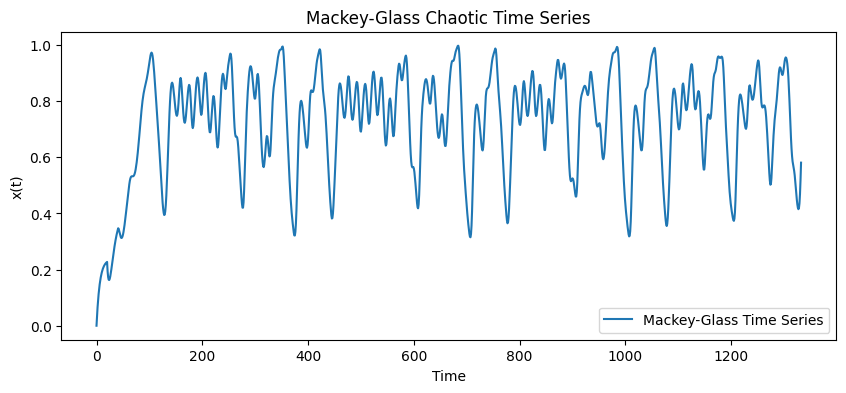

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Simulates the Mackey-Glass time series using the 4th-order Runge-Kutta method.
#   As the result will be generated from quantum measurement, we need to scale it to [0..1]
def mackey_glass(beta=0.2, gamma=0.1, n=10, tau=17, dt=0.1, T=1000):
    
    N = int(T / dt)                # Total number of time steps
    delay_steps = int(tau / dt)    # Delay in terms of steps
    x = np.zeros(N + delay_steps)  # Initialize time series with zeros
    x[0:delay_steps] = 1.2         # Initial condition

    for t in range(delay_steps, N + delay_steps - 1):
        x_tau = x[t - delay_steps]  # Delayed term
        dxdt = beta * x_tau / (1 + x_tau**n) - gamma * x[t]  # Mackey-Glass equation
        x[t + 1] = x[t] + dxdt * dt  # Euler integration

    x_min, x_max = np.min(x), np.max(x)
    x = (x - x_min) / (x_max - x_min)

    return x[delay_steps:]  # Return only the valid part of the time series

# Generate and plot the Mackey-Glass time series
# time_series = mackey_glass(dt=1, T=2000)
time_series = mackey_glass(beta=0.17, dt=1.5, T=2000, tau=30)

plt.figure(figsize=(10, 4))
plt.plot(time_series, label='Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

### Prepare trainig and testing data partitions

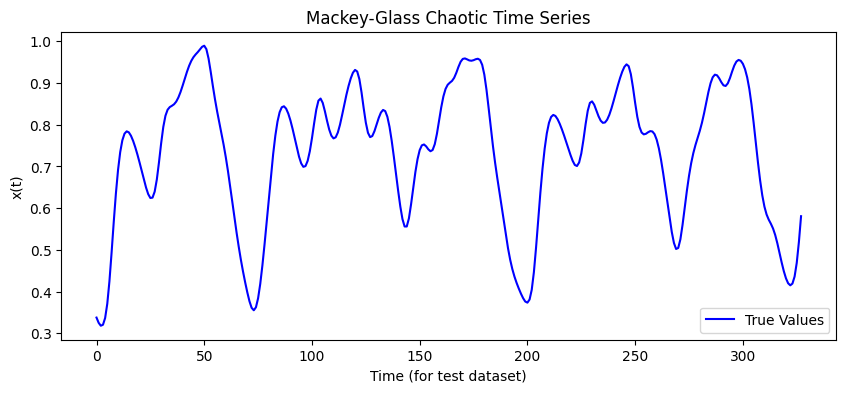

In [3]:
### Prepare the data, scale to [0..1]
def create_io_pairs(data, window_size):
    """
    Create input-output pairs for training/testing.
    """
    inputs = []
    outputs = []
    for i in range(len(data) - window_size):
        inputs.append(data[i:i + window_size])
        outputs.append(data[i + window_size])
    return np.array(inputs), np.array(outputs)

### Data settings
window_size = 5 # 10  # Use the last ws time steps to predict the next step
train_size = 1000  # Use the first trs points for training
test_size = 500   # Use the next tst points for testing

### Create data
train_inputs, train_outputs = create_io_pairs(time_series[:train_size], window_size)
test_inputs, test_outputs = create_io_pairs(time_series[train_size:train_size + test_size], window_size)

### Plot the test set
plt.figure(figsize=(10, 4))
plt.plot(test_outputs, label="True Values", color="blue")
plt.xlabel('Time (for test dataset)')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

## Model development

In [4]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

### Model settings

In [5]:
### Quantum reservoir hyper-parameters
n_qubits = window_size  # Number of qubits in the reservoir
n_layers = 1  # Number of layers in the quantum circuit
seed = 2025   # Random seed used throughout

### Quantum device to use
dev = qml.device("default.qubit", wires=n_qubits, seed=seed)

### Create a quantum feature map

In [6]:
@qml.qnode(dev)
def quantum_feature_map(inputs, weights, biases, n_layers=1, n_qubits=4):
    """
    Quantum circuit that acts as a feature map.
    Its only job is to encode the current classical state into
    multidimensional quantum features.
    
    Args:
        inputs: The current classical state of the ESN.
        weights: Reservoir weights (fixed).
        biases: Input biases (fixed).
    Returns:
        objservables: Quantum features
    """
    # Encode the classical input into the quantum state vector
    for i in range(n_qubits):
        total_angle = inputs[i] + biases[i]
        qml.RX(total_angle, wires=i)

    # Reservoir dynamics (fixed weights)
    for layer in range(n_layers):
        for i in range(n_qubits):
            qml.Rot(*weights[layer, i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

    # Return quantum features (observables)
    return [qml.expval(qml.PauliX(i)) for i in range(n_qubits)] + \
           [qml.expval(qml.PauliY(i)) for i in range(n_qubits)] + \
           [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

### Create and train the reservoir (includes the readout layer)

In [7]:
### The ESN-based training function, which has the following steps:
#   1. Compute the sequence of classical reservoir states
#   2. Map these classical states to quantum features
#   3. Train the readout layer using ridge regression

def train_esn_reservoir(train_inputs, train_outputs, n_layers=1, n_qubits=4, leakage_rate=0.1, lambda_reg=1e-6):
    """
    Trains a quantum reservoir using a classical Echo State Network for memory.
    
    Args:
        train_inputs: Training input data (shape [n_samples, n_features]).
        train_outputs: Target values (shape [n_samples]).
        n_layers: Number of reservoir layers.
        n_qubits: Number of qubits.
        leakage_rate (α): Controls the ESN's memory retention.
        lambda_reg: Ridge regression parameter.      
    Returns:
        W_out: Readout weights.
        weights: Reservoir weights.
        biases: Input biases.
    """
    # Initialize parameters (these are fixed for the reservoir)
    weights = np.random.uniform(-np.pi, np.pi, (n_layers, n_qubits, 3))
    biases = np.random.uniform(-0.5, 0.5, n_qubits)
    n_observables = 3 * n_qubits
    n_samples = len(train_inputs)

    # 1. Compute the classical ESN states
    classical_states = np.zeros((n_samples, n_qubits))
    current_classical_state = np.zeros(n_qubits)

    # Update classical state using the ESN rule
    for t in range(n_samples):
        # The ESN state update equation
        # Note: We broadcast the scalar input across the state vector
        current_classical_state = \
            (1 - leakage_rate) * current_classical_state + \
            leakage_rate * train_inputs[t]
        classical_states[t] = current_classical_state

    # 2. Map classical states to quantum features
    quantum_features = np.zeros((n_samples, n_observables))
    for t in range(n_samples):
        quantum_features[t] = quantum_feature_map(
            inputs=classical_states[t], weights=weights, biases=biases,
            n_layers=n_layers, n_qubits=n_qubits
        )
    
    # 3. Train the readout layer using Ridge regression
    R = quantum_features
    Y = train_outputs.reshape(-1, 1)
    I = np.eye(n_observables)
    W_out = np.linalg.solve(R.T @ R + lambda_reg * I, R.T @ Y).flatten()
    
    return W_out, weights, biases

### Predict test targets

In [8]:
### The ESN-based prediction function.
#   It simulates the ESN state evolution and uses the quantum feature map
#   at each time step to make its prediction.

def predict_esn(test_inputs, weights, biases, W_out, n_layers=1, n_qubits=4, leakage_rate=0.1):
    """
    Makes predictions using the trained ESN-Quantum Reservoir model.
    
    Args:
        test_inputs: Test input data (shape [n_samples, n_features]).
        weights: Reservoir weights.
        biases: Input biases.
        W_out: Readout weights.
        leakage_rate (gamma): Controls the ESN's memory retention.
    Returns:
        predictions: Target test values (shape [n_samples]).
    """
    # Initialize predictoins and the classical state
    predictions = [] 
    current_classical_state = np.zeros(n_qubits)

    for input_val in test_inputs:
        
        # Update classical state using the ESN rule
        current_classical_state = \
            (1 - leakage_rate) * current_classical_state + \
            leakage_rate * input_val
        
        # Get quantum features for the current classical state
        q_features = quantum_feature_map(
            inputs=current_classical_state, weights=weights, biases=biases,
            n_layers=n_layers, n_qubits=n_qubits 
        )
        
        # Predict using the trained readout weights
        y_pred = np.dot(W_out, q_features)
        predictions.append(y_pred)
        
    return np.array(predictions)

### Test the QRC to demonstrate the memory effect

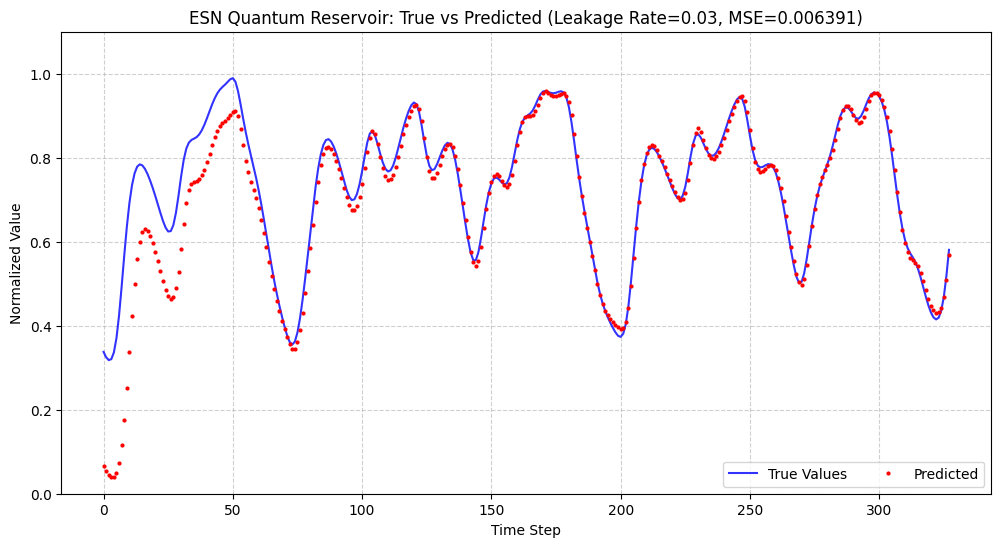

In [9]:
### Conduct a single test

# For reproducibility
np.random.seed(seed)

# Select leakage rate which relies on memory
test_leakage = 0.03

# Create the reservoir and train it
W_out, weights, biases = train_esn_reservoir(
    train_inputs, 
    train_outputs, 
    n_layers=n_layers, 
    n_qubits=n_qubits,
    leakage_rate=test_leakage
)

# Predict test targets
test_preds = predict_esn(test_inputs, weights, biases, W_out, 
                         n_layers=n_layers, n_qubits=n_qubits, leakage_rate=test_leakage)
mse = np.mean((test_preds - test_outputs)**2)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_outputs, label="True Values", color="blue", alpha=0.8)
plt.plot(test_preds, label="Predicted", color="red", linestyle="", marker='.', markersize=4)
plt.xlabel("Time Step")
plt.ylabel("Normalized Value")
plt.ylim(0, 1.1)
plt.title(f'ESN Quantum Reservoir: True vs Predicted (Leakage Rate={test_leakage}, MSE={mse:0.6f})')
plt.legend(loc='lower right', ncol=2)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Experiment with leakage

In [10]:
# Train with different leakage rates to find the optimum
leakage_rates = [0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
mse_scores = []
best_mse = float(np.inf)
best_params = None

# Try different leakage rates
for rate in leakage_rates:
    # For reproducibility
    # and consistency with above test
    np.random.seed(seed)
    
    W_out, weights, biases = train_esn_reservoir(
        train_inputs, 
        train_outputs, 
        n_layers=n_layers, 
        n_qubits=n_qubits,
        leakage_rate=rate
    )
    
    test_preds = predict_esn(test_inputs, weights, biases, W_out, 
                             n_layers=n_layers, n_qubits=n_qubits, leakage_rate=rate)
    current_mse = np.mean((test_preds - test_outputs)**2)
    
    mse_scores.append(current_mse)
    current_params = (W_out, weights, biases, rate, current_mse)
    print(f'Tested leakage rate: {rate:0.3f}, mse: {current_mse:0.6f}')
    
    if current_mse < best_mse:
        best_mse = current_mse
        best_params = current_params

Tested leakage rate: 0.010, mse: 0.013895
Tested leakage rate: 0.030, mse: 0.006391
Tested leakage rate: 0.050, mse: 0.003226
Tested leakage rate: 0.070, mse: 0.001797
Tested leakage rate: 0.100, mse: 0.000969
Tested leakage rate: 0.200, mse: 0.000438
Tested leakage rate: 0.300, mse: 0.000311
Tested leakage rate: 0.400, mse: 0.000221
Tested leakage rate: 0.500, mse: 0.000154
Tested leakage rate: 0.600, mse: 0.000104
Tested leakage rate: 0.700, mse: 0.000068
Tested leakage rate: 0.800, mse: 0.000044
Tested leakage rate: 0.900, mse: 0.000030
Tested leakage rate: 0.950, mse: 0.000027
Tested leakage rate: 0.990, mse: 0.000025


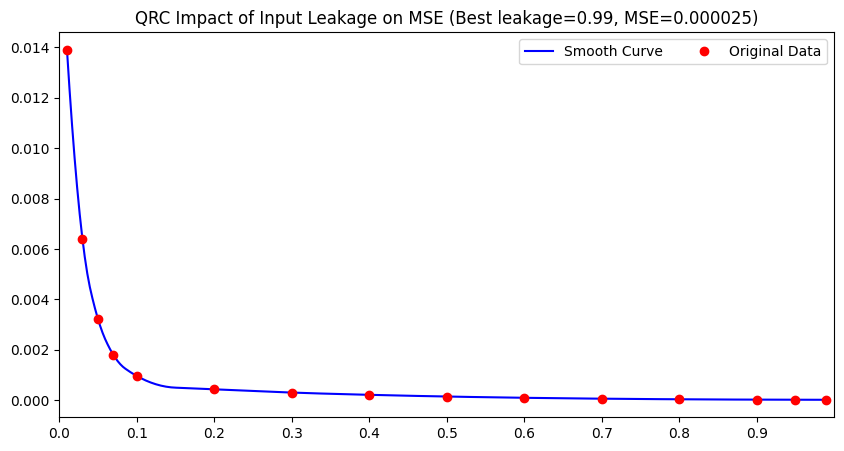

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Example data
X = np.array(leakage_rates)
y = np.array(mse_scores)
best_rate = best_params[3]

# Generate smooth curve using spline interpolation
X_smooth = np.linspace(X.min(), X.max(), 300)  # 300 points for smoothness
spline = make_interp_spline(X, y, k=2)  # Cubic spline (k=3)
y_smooth = spline(X_smooth)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(X_smooth, y_smooth, '-', color="blue", label="Smooth Curve")  # Smoothed line
plt.plot(X, y, 'o', color="red", label="Original Data")  # Original points
plt.title(f'QRC Impact of Input Leakage on MSE (Best leakage={best_rate}, MSE={best_mse:0.6f})')
plt.xlim(0, 1)
start, end = plt.xlim()
plt.xticks(np.arange(start, end, 0.1))
plt.legend(ncol=2)
plt.show()

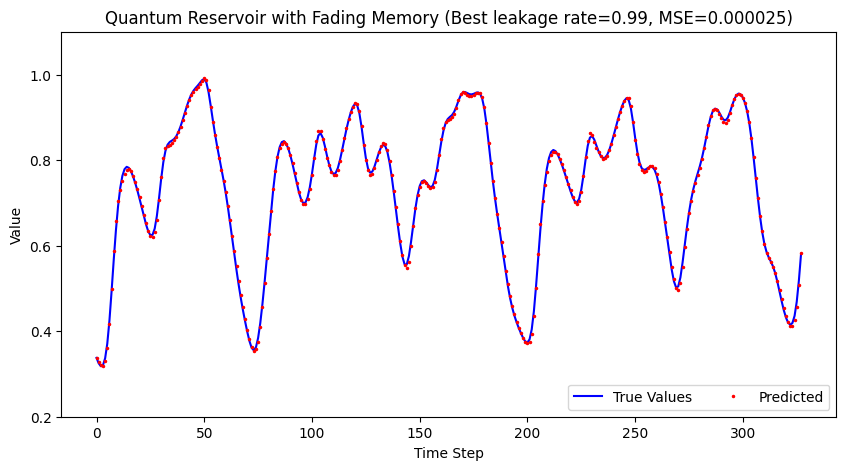

In [12]:
# Use best parameters for final prediction
W_out, weights, biases, best_rate, best_mse = best_params
plt.figure(figsize=(10, 5))
plt.plot(test_outputs, label="True Values", color="blue")
plt.plot(test_preds, label=f"Predicted", color="red", linestyle="", marker='.', markersize=3)
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.ylim(0.2, 1.1)
plt.title(f'Quantum Reservoir with Fading Memory (Best leakage rate={best_rate}, MSE={best_mse:0.6f})')
plt.legend(loc='lower right', ncol=2)
plt.show()

## Write your observations here
The workshop version of the QRC has been completely rewritten as follows:
- Observation 1: 
  - Mackey-Glass time series generator used to produce values of arbitrary range. Considering that the
    time series is split into windows with both X and y vectors using these values, and the estimated y values
    are produced in the process of the expectation value measurement, the sub-range of [-1..1] is more appropriate.
    The function was subsequently changed to scale the time series values to a range of [0..1].
- Observation 2:
  - The second issue was an invalid assumption that the quantum reservoir is in the exponential Hamiltonian space.
    However, the circuit measures the expectation values of Pauli observables (X, Y, and Z) for each qubit,
    which results in the space $3 \times \textit{the number of qubits}$. Considering that the time series window
    was of size 10, and the number of qubits used was 4, this shifted the input dimensionality from 10 to 12 only,
    resulting in the QRC poor performance. For the purpose of illustration, in this notebook, we decreased the
    window size to 5 and retained 4 qubits to generate the quantum reservoir, which increased the input dimensionality
    from 5 to 12, with much better results. Increasing the number of qubits further, e.g. to 6, produces a much better
    fit for the Mackey-Glass time series.
- Observation 3:
  - A few other corrections have also been made, e.g. ensuring that the same leakage rate is passed to the
    reservoir training and prediction, and that the random seed is used consistently in a single test as well as
    in the test of different leakage rates. Small plotting adjustments have also been made
    (also to ensure comparability with the quantum QRC).
- Observation 4:
  - As the original QRC did not show an impact of memory, the model has been rewritten to incorporate Echo State Networks (ESNs) to
    classically implement the reservoir's memory dynamics, and quantum processing to act as a stateless feature map, which has the
    sole responsibility for taking the current classical state and mapping it to a vector of quantum observables.
- Observation 5:
- Observation 6:
- Observation 7:

# Software in use (Linux)

In [13]:
import os
os.system('pip list | grep -e PennyLane -e torch');

PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
PennyLane_Lightning_GPU   0.40.0
PennyLane-Rigetti         0.40.0
torch                     2.6.0+cu126
torch-geometric           2.6.1
torchaudio                2.6.0+cu126
torcheval                 0.0.7
torchsummary              1.5.1
torchvision               0.21.0+cu126
